<a href="https://colab.research.google.com/github/kaitken17/understand_nlp/blob/master/sythetic_analysis_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 12.6MB/s 


In [ ]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [ ]:
# Skips any tests and just runs function definitions
run_tests = False

# Synthetic Data

#### Function Defs

In [ ]:
def generateInputWordBank(toy_params):
  """ Creates the word bank based on various inputs.
  words contains words that can be added to phrase
  all_words contains all possible words including special character words """
  base_words = toy_params['base_words']
  words = ['I'+str(i) for i in range(base_words)]

  all_words = words.copy()

  if toy_params['var_length']:
    all_words.append('<pad>')
  return all_words, words

def make_toy_phrase(toy_params):
  """ Creates a single toy phrase from the word bank """
  
  if toy_params['var_length']:
    phrase_length = np.random.randint(toy_params['min_phrase_len'], toy_params['phrase_length'])
  else:
    phrase_length = toy_params['phrase_length']
  in_words = toy_params['phrase_words'] # only generates phrases from words that can be in a phrase
  phrase = []
  n_words = len(in_words)

  for idx in range(phrase_length):
    next_word = False
    while not next_word: # This infrastructure saved for implementing rules later
      next_word = False
      word_idx = np.random.randint(n_words)
      next_word = True
    
    phrase.append(in_words[word_idx])

  if toy_params['var_length']: # Adds padding if variable length
    phrase.extend(['<pad>' for _ in range(toy_params['phrase_length'] - phrase_length)])

  return phrase

def generateOutputWordBank(toy_params):
  """ Generates the output word bank and translation dictionary which is used to translate phrases """
  base_words = toy_params['base_words']
  
  output_words = []
  base_word_vals = {}
  for i in range(base_words):
    base_word_vals['I'+str(i)] = 'O'+str(i)
    output_words.append('O'+str(i))
  if 'prev0' in toy_params['rules']:
    output_words.append('O0P')

  if toy_params['var_length']: 
    output_words.append('<pad>')
    base_word_vals['<pad>'] = '<pad>' # amount of padding in input = amount in output

  return output_words, base_word_vals

def translate_toy_phrase(toy_phrase, toy_params):
  """ Evaluates a single toy phrase and returns another phrase """
  base_words = toy_params['base_words']
  translations = toy_params['translations']
  phrase_length = len(toy_phrase)

  out_phrase = []

  for idx in range(phrase_length):
    word_found = False
    # Various rule checks
    if 'prev0' in toy_params['rules'] and idx > 1:
      if toy_phrase[idx] == 'I0' and toy_phrase[idx-1] == 'I0':
        word_found = True
        out_phrase.append('O0P')
    
    # Regular translation
    if not word_found and toy_phrase[idx] in list(translations.keys()):
      out_phrase.append(translations[toy_phrase[idx]])

  return out_phrase

def wordToIndex(word, word_bank):
  """ Converts a word into corresponding index in words """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def eosTensor(word_bank):
  """ Returns <1 x n_words> EoS Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """ Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors) 
  Works for both inputs phrases and output phrases """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def tensorToPhrase(tensor, word_bank):
  """ Turn an array of one-hot letter vectors into a phrase """
  phrase = []
  for idx in range(tensor.shape[0]):
      hot_idx = np.argmax(tensor[idx])
      phrase.append(word_bank[hot_idx])
  return phrase

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of nput phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)
  target_mask:

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  in_words = toy_params['in_words']
  out_words = toy_params['out_words']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'

  in_phrase = make_toy_phrase(toy_params)
  in_phrase_tensor = phraseToTensor(in_phrase, toy_params['in_words'])
  out_phrase = translate_toy_phrase(in_phrase, toy_params)
  out_phrase_tensor = phraseToTensor(out_phrase, toy_params['out_words'])

  # Determines phrase length (+1 for EoS character, -1 because index)
  phrase_length = out_phrase.index('<pad>') if toy_params['var_length'] else toy_params['phrase_length']-1
  target_mask = np.array(phrase_length, dtype=int) # When target is defined.
  
  return out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, target_mask

#### Toy Data Tests

In [ ]:
# Various tests/confirmations of phrase generation
run_tests = True
if run_tests:

  toy_params = {
    'phrase_length': 5,
    'var_length': True,
    'min_phrase_len': 2,
    'base_words': 3,
    'loss_type': 'XE',
    'rules': [], #prev0
  }

  toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

  print('Input words:', toy_params['in_words'])
  print('Input phrase words:', toy_params['phrase_words'])
  print('Output words:', toy_params['out_words'])
  print('Translation dic:', toy_params['translations'])

  # Makes five phrases and reports scores
  print('Three phrases and translations:')
  for i in range(3):
    toy_phrase = make_toy_phrase(toy_params)
    print('Input phrase:', toy_phrase)
    out_phrase = translate_toy_phrase(toy_phrase, toy_params)
    print('Output phrase:', out_phrase)

  out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Input phrase:', in_phrase)
  print('Input phrase tensor:', in_phrase_tensor)
  print('Output phrase:', out_phrase)
  print('Output phrase tensor:', out_phrase_tensor)
  print('Target mask:', target_mask)

Input words: ['I0', 'I1', 'I2', '<pad>']
Input phrase words: ['I0', 'I1', 'I2']
Output words: ['O0', 'O1', 'O2', '<pad>']
Translation dic: {'I0': 'O0', 'I1': 'O1', 'I2': 'O2', '<pad>': '<pad>'}
Three phrases and translations:
Input phrase: ['I2', 'I1', 'I1', 'I2', '<pad>']
Output phrase: ['O2', 'O1', 'O1', 'O2', '<pad>']
Input phrase: ['I0', 'I1', 'I1', 'I2', '<pad>']
Output phrase: ['O0', 'O1', 'O1', 'O2', '<pad>']
Input phrase: ['I2', 'I1', 'I0', '<pad>', '<pad>']
Output phrase: ['O2', 'O1', 'O0', '<pad>', '<pad>']
Input phrase: ['I2', 'I1', '<pad>', '<pad>', '<pad>']
Input phrase tensor: [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Output phrase: ['O2', 'O1', '<pad>', '<pad>', '<pad>']
Output phrase tensor: [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Target mask: 2


# SCAN Dataset

In [ ]:
def read_and_split_file(file_name: str) -> list:
  text_data = list()
  current_file = os.path.abspath(file_name)
  if os.path.exists(current_file):
    open_file = open(current_file, 'r', encoding="latin-1")
    text_data = open_file.read().split('\n')
    text_data = list(filter(None, text_data))
  return text_data

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks.txt'
text_data = read_and_split_file(path)

In [ ]:
# all_in_words = ['run', 'walk', 'look', 'jump', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', 'after']
# all_out_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT']

input_words = ['run', 'walk', 'jump', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and']
output_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT']

in_phrases = []
out_phrases = []
max_in = 0
max_out = 0

for i in range(len(text_data)): # filters phrases based on words in input_words
  in_idx = text_data[i].find('IN: ') + 4
  out_idx = text_data[i].find('OUT: ') + 5
  input = text_data[i][in_idx:out_idx-6]
  output = text_data[i][out_idx:]
  input_phrase = input.split(' ')
  output_phrase = output.split(' ')

  if all([input_phrase[j] in input_words for j in range(len(input_phrase))]):
    in_phrases.append(input_phrase)
    out_phrases.append(output_phrase)
    if len(input_phrase) > max_in: max_in = len(input_phrase)
    if len(output_phrase) > max_out: max_out = len(output_phrase)

print(f'Kept {len(in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out}')

# Pads phrases and converts them to tensors
input_words.append('<pad>')
output_words.append('<pad>')
max_in += 1
max_out += 1

scan_inputs_np = np.zeros((len(in_phrases), max_in, len(input_words)))
scan_targets_np = np.zeros((len(out_phrases), max_out, len(output_words)))
scan_target_masks_np = np.zeros((len(in_phrases),))

for i in range(len(in_phrases)):
  scan_target_masks_np[i] = len(out_phrases[i]) + 1
  in_phrases[i].extend(['<pad>' for _ in range(max_in - len(in_phrases[i]))])
  out_phrases[i].extend(['<pad>' for _ in range(max_out - len(out_phrases[i]))])

  scan_inputs_np[i] = phraseToTensor(in_phrases[i], input_words)
  scan_targets_np[i] = phraseToTensor(out_phrases[i], output_words)

  # print('Input:', input_phrase)
  # print('Input tensor:', in_phrase_tensor)
  # print('Output:', output_phrase)
  # print('Output tensor:', out_phrase_tensor

# Converts to JAX arrays
scan_inputs = jnp.asarray(scan_inputs_np)  
scan_targets = jnp.asarray(scan_targets_np)
scan_target_masks = jnp.asarray(scan_target_masks_np, dtype=jnp.int32)

scan_data = {
  'inputs': scan_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
  'labels': scan_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
  'index': scan_target_masks, # Target mask: phrase_len
}

# Sets toy parameters to match SCAN data so same code can be used below
toy_params = {
  'phrase_length': max_out,
  'var_length': True,
  'loss_type': 'XE',
  'in_words': input_words,
  'out_words': output_words,
}

Kept 6642/20910 phrases. // Max in: 9 // Max out: 48


In [ ]:
idx = 8
print('Input:', in_phrases[idx])
print('Input tensor shape:', scan_inputs[idx].shape)
print('Index:', scan_target_masks[idx])
print('Output:', out_phrases[idx])
print('Output tensor shape:', scan_targets[idx].shape)

Input: ['run', 'right', 'thrice', 'and', 'turn', 'around', 'left', 'twice', '<pad>', '<pad>']
Input tensor shape: (10, 12)
Index: 15
Output: ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Output tensor shape: (49, 7)


# Train and Build Network

#### Training Functions

In [ ]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  phrase_length = rnn_specs['phrase_length']

  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # Attention mechanisms double hidden size
    num_units = 2*rnn_specs['hidden_size']
    print('Doubling hidden units for attention.')
  else:
    num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  def build_cell_rnn(units):
    if rnn_specs['cell_type'] == 'Vanilla':
      cell = renn.rnn.cells.VanillaRNN(units)
    elif rnn_specs['cell_type'] == 'GRU':
      cell = renn.rnn.cells.GRU(units)
    elif rnn_specs['cell_type'] == 'LSTM':
      cell = renn.rnn.cells.LSTM(units)
    elif rnn_specs['cell_type'] == 'UGRNN':
      cell = renn.rnn.cells.UGRNN(units)
    return cell

  def build_readout():
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(num_outputs)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)
    return readout_init, readout_apply

  def build_attention():
    attention_init, attention_apply = attention(phrase_length)  
    return attention_init, attention_apply  

  def init_fun(prng_key, enc_input_shape, dec_input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1, k2, k3 = jax.random.split(prng_key, 4)
    output_shape, rnn_params = cell.init(k0, enc_input_shape[1:])
    
    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']: # Readout size reduced by 1/2 since only uses first half of hidden
      output_shape = output_shape[:-1] + (int(1/2*output_shape[-1]),)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (enc_input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)
    if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      return batch_output_shape, (rnn_params, rnn_params_dec, readout_params)
    elif rnn_specs['arch'] in ['enc_dec_att',]:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      _, att_params = attention_init(k3, (phrase_length,))
      return batch_output_shape, (rnn_params, rnn_params_dec, att_params, readout_params)
    else:
      return batch_output_shape, (rnn_params, readout_params)

  def apply_fun_one_to_one(params, inputs):
    """Applies the RNN in the usual way."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    
    all_logits = renn.rnn.unroll.unroll_rnn(initial_states, inputs, batch_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec(params, inputs):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder"""
    # Destructure parameter tuple.
    rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    
    all_logits = encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec_att(params, inputs):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder and with attention mechanism"""
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(phrase_length)]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    elif rnn_specs['arch'] == 'enc_dec_atth':
      rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    # Softmax across dimension multiplying encoder sequence

    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
      att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      all_logits = encode_decode_attn(initial_states, inputs, rnn_apply, att_apply,
                                      functools.partial(readout_apply, readout_params), zero_context=rnn_specs['zero_context'])
    elif rnn_specs['arch'] in ['enc_dec_atth']:
      dec_seq_size = (toy_params['phrase_length'], inputs.shape[0], len(toy_params['out_words'])) # 0 and 1 swapped to match inputs
      all_logits = encode_decode_attnh(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                                       zero_context=rnn_specs['zero_context'], variable_len=toy_params['var_length'],
                                       dec_seq_size=dec_seq_size)
    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    # last_index.shape = (batch_size, phrase_length)
    last_index = last_index[:, :, jnp.newaxis]
    # sequences.shape = (batch_size, phrase_length, vocab_size)
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def mask_sequences(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len, vocab_size)"""
    # sequences.shape = (batch_size, seq_length, vocab_size)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * jnp.repeat(mask[:,:,jnp.newaxis], sequences.shape[-1], axis=2)

  def mask_sequences_one(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len)"""
    # sequences.shape = (batch_size, seq_length)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * mask

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels, lengths):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)

    xe_loss = -1 * np.mean(mask_sequences_one(jnp.squeeze(logliklihood), lengths))

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    # logits = mask_sequences(all_logits, batch['index'])
    # labels = mask_sequences(batch['labels'], batch['index'])
    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    # xe_loss = xe_loss_fn(logits, labels)
    xe_loss = xe_loss_fn(all_logits, batch['labels'], batch['index'])

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_sequences(all_logits, batch['index'])
    labels = mask_sequences(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return labels_max == predictions

  # Build the RNN cell.
  cell = build_cell_rnn(num_units)
  readout_init, readout_apply = build_readout()
  
  if rnn_specs['arch'] == 'enc_dec':
    cell_dec = build_cell_rnn(num_units) # decoder cell
    apply_fun = apply_fun_enc_dec
  elif rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
    cell_dec = build_cell_rnn(num_units) # decoder cell can take shorted input now
    attention_init, attention_apply = build_attention() # Uses attention with fixed shorts or learnable parameters
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] in ['enc_dec_atth']:
    cell_dec = build_cell_rnn(num_units) # decoder cell can take shorted input now
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] == 'enc_dec_one':
    apply_fun = apply_fun_enc_dec_one
  elif rnn_specs['arch'] == 'one_to_one':
    apply_fun = apply_fun_one_to_one
  else:
    raise ValueError('Rnn arch not recognized.')
    
  return init_fun, apply_fun, mask_sequences, loss_fun, accuracy_fun

def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step with clipped gradients."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    # input shape = (seq_length, hidden_dims)
    # output shape = (seq_length, out_dim)
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

def attention(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a attention matrix."""
  def init_fun(rng, input_shape):
    # input shape = (# encoders,)
    # output shape = (# decoders,)
    output_shape = (out_dim,)
    k1, _ = jax.random.split(rng)
    att_mat = W_init(k1, (input_shape[0], out_dim))
    return output_shape, (att_mat)
  def apply_fun(params, inputs, **kwargs):
    att_mat = params
    return jnp.dot(inputs, att_mat)
  return init_fun, apply_fun

In [ ]:
# Synthetic data functions

def generate_data(dataset_size, toy_params, rnn_specs):
  """
  Generate training data in numpy and then converts to JAX arrays
  """

  out_size = rnn_specs['output_size']

  syn_out_phrases = []
  syn_in_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['in_words'])))
  # syn_target_masks_np = []
  syn_target_masks_np = np.zeros((dataset_size,))

  start_time = time.time()
  for trial in range(dataset_size):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = sentiment_tensor
    syn_inputs_np[trial, :, :] = phrase_tensor
    syn_target_masks_np[trial] = target_mask
    # syn_target_masks_np.append(target_mask)

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays
  syn_targets = jnp.asarray(syn_targets_np)
  syn_inputs = jnp.asarray(syn_inputs_np)  
  syn_target_masks = jnp.asarray(syn_target_masks_np, dtype=jnp.int32)
  # syn_target_masks =  syn_target_masks_np

  syn_data = {
    'inputs': syn_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': syn_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': syn_target_masks, # Target mask: list of integers up to phrase_len
  }

  return syn_data

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]

  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for dataset in range(train_params['n_datasets']):
    # Generates new train/test datasets 
    syn_data = generate_data(train_set_size, toy_params, rnn_specs)
    syn_data_test = generate_data(test_set_size, toy_params, rnn_specs)

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        print('Shuffling Data')
        syn_data = shuffle_data(syn_data)

      print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
          'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
          'index': syn_data['index'][batch*batch_size:(batch+1)*batch_size], # Target mask: list of integers up to phrase_len
        }

        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
          test_acc = test_accuracy(get_params(opt_state), syn_data_test)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs):
  """ Train SCAN data (imported elsewhere) for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']
  
  num_batchs = int(np.floor(scan_data['inputs'].shape[0]/batch_size))
  print(f'Running {num_batchs} batches per epoch.')

  for epoch in range(train_params['epochs']):
    # Shuffles training data after first epoch
    if epoch > 0:
      scan_data = shuffle_data(scan_data)

    start_time = time.time()  
    avg_loss = 0 
    for step in range(total_steps, total_steps+num_batchs):
      batch = step - total_steps 
      batch_data = {
        'inputs': scan_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
        'labels': scan_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
        'index': scan_data['index'][batch*batch_size:(batch+1)*batch_size], # Target mask: list of integers up to phrase_len
      }

      global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
      train_losses.append(loss)
      avg_loss += loss

      if (global_step+1) % print_every == 0:
        test_acc = test_accuracy(get_params(opt_state), scan_data)

        batch_time = time.time() - start_time
        step_size = decay_fun(global_step)
        s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
        print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
        start_time = time.time()
        avg_loss = 0

    train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'
  if 'zero_context' not in rnn_specs: rnn_specs['zero_context'] = False

  return train_params, toy_params, rnn_specs

#### Building Tests

In [ ]:
#### Functions for encoder->decoder structure

def identity(x):
  """Identity function f(x) = x."""
  return x

def encode_decode(initial_states, input_sequences, rnn_update, readout=identity, return_hidden=False):

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states """

    next_state = enc_update(inputs, state)
    outputs = identity(next_state)
    return next_state, outputs

  def _step_d(carry, null_inputs):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry

    next_state = dec_update(inputs, state)
    outputs = readout(next_state)
    
    # Convers outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_null = jnp.zeros(input_sequences.shape) # These inputs aren't used
  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq_null)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attn(initial_states, input_sequences, rnn_update, attention_apply, readout=identity,
                       return_hidden=False, zero_context=False):
  """ Encoder decoder structure with attention/shorts"""

  hidden_state_keep = int(1/2*initial_states.shape[-1])
  # print('Keeping first {} of {} hidden'.format(hidden_state_keep, initial_states.shape[-1]))

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    inputs = (batch_size, input_size)
    """
    if zero_context:
      state = jnp.zeros(state.shape)
    # Zeros second half of the hidden state
    state = jnp.concatenate([state[:,:hidden_state_keep], jnp.zeros((state.shape[0], hidden_state_keep))], axis=1)

    next_state = enc_update(inputs, state)
    outputs = identity(next_state[:,:hidden_state_keep])
    return next_state, outputs

  def _step_d(carry, seq_input):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry # unpack carry
    if zero_context:
      print('Zeroing Context')
      state = jnp.zeros(state.shape)
    # Concatanate seq_input with hidden to get new hidden (for attention)
    state = jnp.concatenate([state[:,:hidden_state_keep], seq_input], axis=1)

    next_state = dec_update(inputs, state)
    # Only first half of hidden state goes to readout
    outputs = readout(next_state[:,:hidden_state_keep])
    
    # Converts outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state[:,:hidden_state_keep]

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_hidden = enc_outs # Hidden states of encoder (enc_seq_len, batch_size, hidden_size)

  # Multiplies hidden states by the attend matrix (with some swap axes to get everything the right shape)
  input_seq = jnp.swapaxes(attention_apply(jnp.swapaxes(input_seq_hidden, 0, 2)), 0, 2)

  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attnh(initial_states, input_sequences, rnn_update, readout=identity,
                        return_hidden=False, zero_context=False, variable_len=False, dec_seq_size=None):
  """ Encoder decoder structure with attention, this time using the hidden state overlap to find attention.
  Note this requires a slightly different arcitecture than what was used above. """

  eos_idx = input_sequences.shape[-1] - 1 # assumes eos is last word in vocab
  hidden_state_keep = int(1/2*initial_states.shape[-1])

  def _step_e(carry, seq_input):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    inputs = (batch_size, input_size)
    """
    old_state, is_eos = carry

    if zero_context:
      old_state = jnp.zeros(old_state.shape)
    # Zeros second half of the hidden state
    state = jnp.concatenate([old_state[:,:hidden_state_keep], jnp.zeros((old_state.shape[0], hidden_state_keep))], axis=1)
    next_state = enc_update(seq_input, state)
    # determines which state to carry to next input 
    carried_state = jnp.where(is_eos[:, np.newaxis], old_state, next_state)
    outputs = identity(carried_state[:,:hidden_state_keep])
    
    # Update is_eos (true if one-hot in eos_idx)
    if variable_len:
      is_eos = jnp.logical_or(is_eos, seq_input[:, eos_idx])
    
    return (carried_state, is_eos), outputs

  def _step_d(carry, seq_input):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry # unpack carry into hidden sate and previous input
    if zero_context:
      print('Zeroing Context')
      state = jnp.zeros(state.shape)

    null_hidden_input = jnp.zeros(state[:,:hidden_state_keep].shape)

    # Concatanate hidden with zeros to get new hidden (this is a placeholder for additional attention mechanisms later on)
    state = jnp.concatenate([state[:,:hidden_state_keep], null_hidden_input], axis=1)
    next_state = dec_update(inputs, state)

    # Uses the output of the decoder to calculate the attention state
    # (batch, hidden) x (seq_len, batch, hidden) -> (seq_len, batch)
    attention_row = jax.nn.softmax(jnp.einsum('ij,kij->ki', next_state[:,:hidden_state_keep], input_seq_hidden), axis=0)
    # (seq_len, batch) x (seq_len, batch, hidden) -> (batch, hidden)
    attention_state = jnp.einsum('ij,ijk->jk', attention_row, input_seq_hidden)

    # Concatenated first half of hidden state and attention state go to readout
    outputs = readout(jnp.concatenate([next_state[:,:hidden_state_keep], attention_state], axis=1))
    
    # Converts outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state[:,:hidden_state_keep]

  enc_update, dec_update = rnn_update
  # Run encoder
  is_eos = jnp.zeros(input_sequences.shape[0], dtype=np.bool) # (batch_size)
  initial_carry = (initial_states, is_eos)
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_carry, input_sequences)

  encode_final_hs, _ = encode_final
  if dec_seq_size == None: # Assumes same dimension of output sequence as input sequence if left blank
    dec_seq_size = input_sequences.shape[:-1] + (rnn_specs['output_size'],)
  eos_input = jnp.zeros(dec_seq_size[1:])
  init_val = (encode_final_hs, eos_input)

  # Run decoder
  input_seq_hidden = enc_outs # Hidden states of encoder (enc_seq_len, batch_size, hidden_size)

  # Just directly accesses the encoder hidden sequences, so no need to pass in any inputs
  input_seq_null = jnp.zeros(dec_seq_size) # These inputs aren't used
  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq_null)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

In [ ]:
if run_tests:

  seed = 342343
  prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

  ########## Toy data parameters ##########
  toy_params = {
    'phrase_length': 5,
    'base_words': 3,
    'var_length': False,
    'min_phrase_len': 2,
    'loss_type': 'XE',
    'rules': [None,] # prev0
  }

  toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

  ########## RNN hyperparameters ##########
  rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_atth',                           # Type of architecture
    'shorts': (),
    'zero_context': False,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': True,                                 # Include a bias with the readout
    'ro_simplex_init': False,
    'phrase_length': toy_params['phrase_length']     # Needed to build the attention matrix
  }

  ########## Train hyperparameters ##########

  train_params = {
    'batch_size': 2,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
  }

  train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 

  # Generate the data to run through the RNN
  syn_data = generate_data(train_params['train_set_size'], toy_params, rnn_specs)
  
  print('Vocab:', toy_params['in_words'])
  print('Sythetic lengths:', syn_data['index'])

  # Initialize the optimizer.
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  if rnn_specs['arch'] == 'enc_dec_att':
    rnn_params, rnn_params_dec, att_params, readout_params = initial_params
  elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
    rnn_params, rnn_params_dec, readout_params = initial_params
  else:
    rnn_params, readout_params = initial_params

  # cell = build_cell(rnn_specs)
  out_logits = apply_fun(initial_params, syn_data['inputs'])

  print('Output logits shape:', out_logits.shape)
  print('Output logits:', out_logits)
  # print('Output logits:', out_logits[0, :5, :2])
  # print('Output logits:', out_logits[1, :5, :2])
  print('Output labels:', syn_data['labels'])

Sythentic data generated in: 0.00 sec.
Vocab: ['I0', 'I1', 'I2']
Sythetic lengths: [4 4]
Doubling hidden units for attention.
Output logits shape: (2, 5, 3)
Output logits: [[[-0.02904212  0.00312051 -0.02869741]
  [-0.01683338 -0.04755636 -0.03626994]
  [-0.01262543 -0.01695025 -0.01624355]
  [-0.0014455  -0.00365104 -0.01557148]
  [ 0.00931553  0.00095663 -0.02073723]]

 [[-0.05773365  0.03158399 -0.00320857]
  [-0.02817337 -0.02954858 -0.01477754]
  [-0.05461191 -0.04890962 -0.05019397]
  [-0.03286672 -0.05793246 -0.0382733 ]
  [-0.02435831 -0.01453812 -0.01048659]]]
Output labels: [[[1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [1. 0. 0.]
  [0. 0. 1.]
  [1. 0. 0.]
  [0. 0. 1.]]]


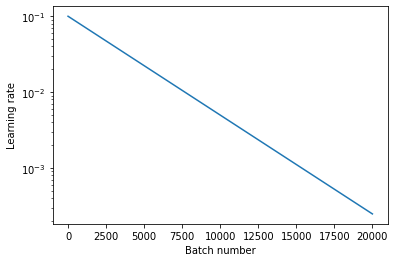

In [ ]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [ ]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

data_type = 'scan' # toy or scan

if data_type == 'toy':
  ########## Toy data parameters ##########
  toy_params = {
    'phrase_length': 25,
    'base_words': 3,
    'var_length': True,
    'min_phrase_len': 15,
    'loss_type': 'XE',
    'rules': [] # prev0
  }

  toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'arch': 'enc_dec_atth',                  # Architecture, supports 'one_to_one', 'enc_dec', 'enc_dec_short', 'enc_dec_att',
                                          # 'enc_dec_atth'
  'shorts': (),
  'zero_context': False,
  'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
  'hidden_size': 128,                              # Number of units in the RNN
  'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
  'ro_bias': False,                                # Include a bias with the readout
  'phrase_length': toy_params['phrase_length']     # Needed to build the attention matrix
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 5e-4,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 4,                           # Number of new train sets to generate total (this is slow)
  'epochs': 200,                               # How many times to go through each train set completely
  'test_set_size': 200,
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('# Input words:', len(toy_params['in_words']), 'Input words:', toy_params['in_words'])
print('# Output words:', len(toy_params['out_words']), 'Output words:', toy_params['out_words'])
print('Architecture:', rnn_specs['arch'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_4classrgb_01-12-23-30is01_RObias_l2is5e-3.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 12000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
if data_type == 'toy':
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)
elif data_type == 'scan':
  opt_state, train_params = train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
if rnn_specs['arch'] == 'enc_dec_att':
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
  rnn_params, rnn_params_dec, readout_params = final_params
else:
  rnn_params, readout_params = final_params

# Input words: 12 Input words: ['run', 'walk', 'jump', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', '<pad>']
# Output words: 7 Output words: ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT', '<pad>']
Architecture: enc_dec_atth
Doubling hidden units for attention.
Running 51 batches per epoch.
Step 100 in 2.19 sec, step size: 0.09707, test acc 0.8488, avg training loss 0.5440
Step 200 in 1.46 sec, step size: 0.09420, test acc 0.8560, avg training loss 0.4526
Step 300 in 1.41 sec, step size: 0.09142, test acc 0.8689, avg training loss 0.3709
Step 400 in 1.34 sec, step size: 0.08872, test acc 0.8808, avg training loss 0.3105
Step 500 in 1.29 sec, step size: 0.08610, test acc 0.8877, avg training loss 0.2633
Step 600 in 1.26 sec, step size: 0.08355, test acc 0.8892, avg training loss 0.2247
Step 700 in 1.19 sec, step size: 0.08108, test acc 0.8907, avg training loss 0.1891
Step 800 in 1.12 sec, step size: 0.07868, test acc 0.8902, avg traini

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_xe_noRO_l2is2e-4.pickle'

train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_4classrgb_01-12-23-30is01_noRO_l2is5e-3.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

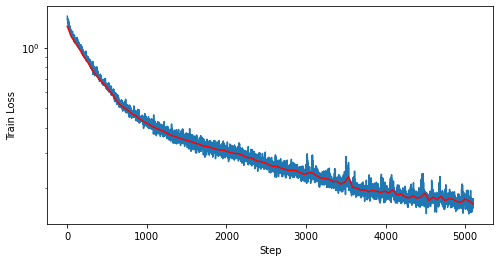

In [ ]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [ ]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  hm = 1 # hidden state size modifier
  if rnn_specs['arch'] == 'enc_dec_short':
    hm = 2

  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(hm * rnn_specs['hidden_size'])
  if rnn_specs['arch'] == 'one_to_one':
     return cell
  else:
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(rnn_specs['output_size'])
    else:
      readout_init, readout_apply = Dense_nobias(rnn_specs['output_size'])
    return cell, readout_apply

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  if rnn_specs['arch'] == 'enc_dec': # Vanilla encoder decoder
    rnn_params_enc, rnn_params_dec, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    
    return encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                         return_hidden=True)
  elif rnn_specs['arch'] in ['enc_dec_att', 'enc_dec_short']: # Encoder decoder with attention/shorts
    def attention_apply(params, inputs):
      att_mat = params
      return jnp.dot(inputs, att_mat)
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(toy_params['phrase_length'])]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      
    return encode_decode_attn(initial_states, inputs, rnn_apply, att_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, zero_context=rnn_specs['zero_context'])
  
  elif rnn_specs['arch'] in ['enc_dec_atth']: # Encoder decoder with attention via hidden states
    rnn_params_enc, rnn_params_dec, readout_params = params
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply

    dec_seq_size = (toy_params['phrase_length'], inputs.shape[0], len(toy_params['out_words']))
    return encode_decode_attnh(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, zero_context=rnn_specs['zero_context'], variable_len=toy_params['var_length'],
                             dec_seq_size=dec_seq_size)
  elif rnn_specs['arch'] == 'one_to_one':
    rnn_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
    return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, params, only_final=False):
  """Return RNN states."""
  states = _get_all_states(batch['inputs'], params)
  if only_final: # returns only the final hidden state
    raise NotImplementedError
  else:
    return [h for h in states]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

def generate_labels(toy_params):
  """ Generates all possible labels a phrase can have """
  total_labels = len(toy_params['out_words'])**toy_params['phrase_length']
  labels = []
  for i in range(toy_params['phrase_length']):
    if labels == []:
      labels = [[i] for i in range(len(toy_params['out_words']))]
    else:
      new_labels = []
      for j in range(len(labels)):
        for k in range(len(toy_params['out_words'])):
          temp_label = labels[j].copy()
          temp_label.append(k)
          new_labels.append(temp_label)
      labels = new_labels

  return labels

def apply_fun_enc_dec_short_ext(params, inputs):
  """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder"""
  # Destructure parameter tuple.
  rnn_params_enc, rnn_params_dec, readout_params = params

  # Only gets initial state from encoder, [batch, len, dim]
  initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

  batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
  batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

  rnn_apply = batch_apply_enc, batch_apply_dec
  
  all_logits = encode_decode_short(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                                    shorts=rnn_specs['shorts'], zero_context=rnn_specs['zero_context'])
  return all_logits

def accuracy_fun_ext(params, batch):
    all_logits = apply_fun_enc_dec_short_ext(params, batch['inputs'])
    logits = mask_sequences(all_logits, batch['index'])
    labels = mask_sequences(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return np.mean(labels_max == predictions)

In [ ]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000

# rnn_specs['zero_context'] = True
syn_data_test = generate_data(n_trials, toy_params, rnn_specs)
pts = {}

if rnn_specs['arch'] == 'one_to_one':
  cell = build_cell(rnn_specs)
  hs = rnn_states(syn_data_test, final_params)
else: 
  cell, readout_apply = build_cell(rnn_specs)
  if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
    print('Using two separate cells for encoder and decoder.')
    cell_dec, readout_apply = build_cell(rnn_specs)
  hs = rnn_states(syn_data_test, final_params)
  
  pts['enc'] = np.vstack([h[:len+1] for h, len in zip(hs, syn_data_test['index'])])
  pts['dec'] = np.vstack([h[toy_params['phrase_length']-1:toy_params['phrase_length']+len+1] 
                          for h, len in zip(hs, syn_data_test['index'])]) # includes final encoder hs 
  pts['encf'] = np.vstack([h[len] for h, len in zip(hs, syn_data_test['index'])])
  pts['decf'] = np.vstack([h[toy_params['phrase_length'] + len] for h, len in zip(hs, syn_data_test['index'])])
  print('Points encoder shape:', pts['enc'].shape)
  print('Points decoder shape:', pts['dec'].shape)

pts['all'] = np.vstack(hs)
print('Points all shape:', pts['all'].shape)

# test_acc = accuracy_fun_ext(final_params, syn_data_test)
# print('Test Accuracy:', test_acc)
# rnn_specs['zero_context'] = False

if rnn_specs['arch'] in ['enc_dec_atth']:
  if rnn_specs['ro_bias']: raise NotImplementedError
  hidden_split = rnn_specs['hidden_size']
  readout = readout_params[hidden_split:, :].T
  readout_dec = readout_params[:hidden_split, :].T
  print('Readout_enc/Readout_dec ratio:', np.linalg.norm(readout)/ np.linalg.norm(readout_dec))
else:
  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout = wO.T
print('Readout shape:', readout.shape)

Sythentic data generated in: 0.11 sec.
Using GRU cell
Using two separate cells for encoder and decoder.
Using GRU cell
Points encoder shape: (20599, 128)
Points decoder shape: (21599, 128)
Points all shape: (50000, 128)
Readout_enc/Readout_dec ratio: 5.742956
Readout shape: (4, 128)


In [ ]:
# Filter to only certain subset of labels
phrase_idx = 1
label_val = 2

lbl_idxs = [lbl_idx for lbl_idx in range(len(labels)) if labels[lbl_idx][phrase_idx] == label_val]

hs_filtered = []
for idx in lbl_idxs:
  hs_filtered.extend(states[idx])
pts_filtered = np.vstack(hs_filtered)

pca_filtered = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_filtered.fit_transform(pts_filtered)

explained_var = pca_filtered.explained_variance_ratio_
print('PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_filtered.explained_variance_))

Top 10 components: 0.9881994 ( [0.4322703  0.31962097 0.13963932 0.03415206 0.01584345 0.01537063
 0.01253719 0.00943453 0.00493224 0.0043987 ] )
Participation Ratio: 3.2208069841380333
Copy this: PCA: [0.4322703  0.31962097 0.13963932 0.03415206 0.01584345 0.01537063
 0.01253719 0.00943453 0.00493224 0.0043987 ] PR: 3.2208069841380333
Total labels: 1125899906842624
All hs group into single state list of length: 1000
Readout vec proj via PCA: [[-0.60375524 -0.61600924 -0.57044435 -0.145334  ]
 [ 1.3834661   1.3226885   1.388236    1.3630277 ]
 [-1.6812643  -1.7070343  -1.6914855  -1.6341078 ]
 [ 0.11401737  0.39492074  0.05660047  1.2042576 ]
 [ 2.8279107  -0.28539118 -2.5136042  -0.0158459 ]
 [-1.2639345   3.1041186  -1.7777549  -0.25676018]
 [ 0.50519645  0.6001614   0.4863411   1.2620873 ]
 [ 0.1293436   0.25759938  0.06190922  2.3991585 ]
 [ 0.31140423  0.1345416   0.21778879 -0.20371772]
 [-0.39027706 -0.28799373 -0.5214105   0.274991  ]]
h0 shape (128,)


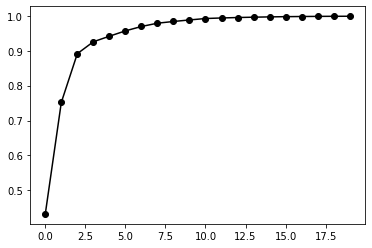

In [ ]:
pc_dims = 10
pts_subset = 'all' # supports 'enc', 'dec', 'all', and 'encf'
no_states = True

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts[pts_subset])
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
total_labels = len(toy_params['out_words'])**toy_params['phrase_length']
print('Total labels:', total_labels)
if no_states: # Groups all hidden state into single state list
  if pts_subset == 'enc':
    states.append([h[:toy_params['phrase_length']] for h in hs])
  elif pts_subset == 'dec':
    states.append([h[toy_params['phrase_length']-1:] for h in hs])
  elif pts_subset == 'all':
    states.append([h for h in hs])
  elif pts_subset == 'encf':
    states.append([h[toy_params['phrase_length']-1] for h in hs])
  labels = [[0]]
  total_labels = 1
  print('All hs group into single state list of length:', len(states[0]))
else: # Groups hidden states into different states based on label
  labels = generate_labels(toy_params)
  for lbl_idx in range(total_labels):
    if pts_subset == 'enc':
      states.append([h[:toy_params['phrase_length']] for h, lbl in zip(hs, syn_data_test['labels']) if list(np.argmax(lbl, axis=1)) == labels[lbl_idx]])
    elif pts_subset == 'dec':
      states.append([h[toy_params['phrase_length']-1:] for h, lbl in zip(hs, syn_data_test['labels']) if list(np.argmax(lbl, axis=1)) == labels[lbl_idx]])
    elif pts_subset == 'all':
      states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if list(np.argmax(lbl, axis=1)) == labels[lbl_idx]])
    elif pts_subset == 'encf':
      states.append([h[toy_params['phrase_length']-1] for h, lbl in zip(hs, syn_data_test['labels']) if list(np.argmax(lbl, axis=1)) == labels[lbl_idx]])
    if total_labels < 30:
      print('Category {} states:'.format(lbl_idx), len(states[lbl_idx]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts[pts_subset])
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
print('h0 shape', h0.shape)

Example phrase length: 17


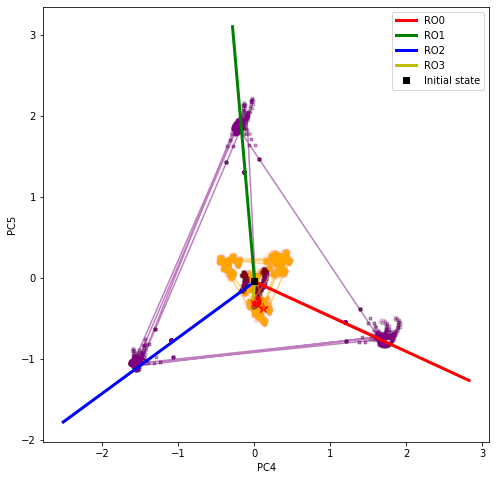

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(8, 8))

lbl_idxs = [i for i in range(total_labels)]
# lbl_idxs = [0, 3, 6]

pc1 = 4
pc2 = 5

# state_labels = ['Positive examples', 'Negative examples']
if total_labels <= 9:
  state_colors = ['r', 'g', 'b', 'y', 'orange', 'm', 'brown', 'gray', 'k']
else:
  state_colors = [(i, 0.0, 0.0) for i in list(np.linspace(0, 1.0, num=total_labels))]
final_hs_idx = 2*toy_params['phrase_length'] if pts_subset == 'all' and not rnn_specs['arch'] == 'one_to_one' else toy_params['phrase_length']
encode_hs_idx = 0 if pts_subset == 'dec' else toy_params['phrase_length']
##### Hidden States #####

pca_h0 = pca.transform(np.atleast_2d(h0)).T

for i in lbl_idxs:
  for state_idx in range(len(states[i])): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    if pts_subset == 'all':
      pl = toy_params['phrase_length']
      plt.scatter(pca_state[pc1][:pl], pca_state[pc2][:pl], color = 'purple', marker='.', alpha=0.01)
      plt.scatter(pca_state[pc1][pl-1:], pca_state[pc2][pl-1:], color = 'orange', marker='.', alpha=0.01)
    else:
      plt.scatter(pca_state[pc1], pca_state[pc2], color = state_colors[i], marker='.', alpha=0.01)
  for state_idx in range(np.min([1, len(states[i])])): # Only plots 1 for each color
    mod_idx = 1 # for easily looking at other paths
    print('Example phrase length:', syn_data_test['index'][state_idx + mod_idx])
    pca_state = pca.transform(states[i][state_idx + mod_idx]).T
    if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
      pca_state = np.concatenate((pca_h0, pca.transform(states[i][state_idx + mod_idx]).T), axis=1) 
    if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
      pca_decf = pca.transform(np.atleast_2d(pts['decf'][state_idx + mod_idx])).T
      plt.scatter(pca_decf[pc1], pca_decf[pc2], color = state_colors[i], marker='*', 
                  s=100.0, alpha=1.0)
    if pts_subset == 'all':
      plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'purple', marker=None, alpha=0.5)
      plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'orange', marker=None, alpha=0.5)
    else:
      plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[i], marker=None, alpha=0.5, label='{}'.format(labels[i]))
    plt.scatter(pca_state[pc1, encode_hs_idx], pca_state[pc2, encode_hs_idx], color = state_colors[i], marker='o', 
                  s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# pca_states = pca.transform(np.vstack(hs)).T
# plt.plot(pca_states[pc1], pca_states[pc2], c = 'k', marker='o', alpha=0.01, label='Hidden sates')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

# path_idxs = [54, 56, 57]
# for path_idx in path_idxs:
#   print('Path labels:', syn_data_test['labels'][path_idx])
#   path_pca = pca.transform(hs[path_idx]).T
#   plt.plot(path_pca[pc1], path_pca[pc2], c='orange', marker='.', label='Random Path')

plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

if total_labels <= 16:
  plt.legend()

#### Readout Vector Analysis

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

# Percentage of readout vector mag in PCA dimensions
if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

print('Readout shape:', readout.shape)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  # print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)

Readout shape: (4, 256)
Readout 0 mag: 3.2603493
Readout 1 mag: 3.2763126
Readout 2 mag: 3.2656975
Readout 3 mag: 2.38192
Angle (1, 0): 114.35718108479566
Angle (2, 0): 114.07247830962201
Angle (2, 1): 114.49495283054398
Angle (3, 0): 104.02737373879762
Angle (3, 1): 104.41045855877613
Angle (3, 2): 103.60045276472597
Avg perc in rest for subspace dim 1: 0.32688840851187706
Avg perc in rest for subspace dim 2: 0.5722723205884297
Avg perc in rest for subspace dim 3: 0.9985332638025284


x 0.99999994
y 1.0000001
x.y -8.940697e-08


Text(0, 0.5, 'RO vec space2')

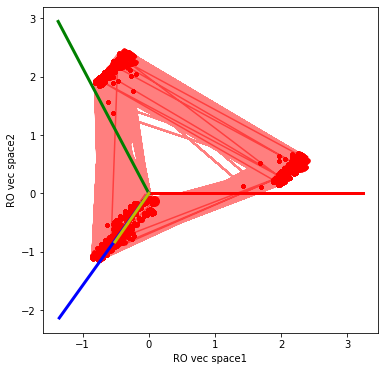

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)

# state_labels = ['Positive examples', 'Negative examples']
if total_labels <= 9:
  state_colors = ['r', 'g', 'b', 'y', 'orange', 'm', 'brown', 'gray', 'k']
else:
  state_colors = [(i, 0.0, 0.0) for i in list(np.linspace(0, 1.0, num=total_labels))]
for i in lbl_idxs:
  for state_idx in range(len(states[i])): # Plots grey final states
    x_vals = np.dot(np.matmul(np.vstack(states[i][state_idx]), proj), x_basis)
    y_vals = np.dot(np.matmul(np.vstack(states[i][state_idx]), proj), y_basis)
    plt.scatter(x_vals, y_vals, color = state_colors[i], marker='.', alpha=0.5)
  for state_idx in range(np.min([1, len(states[i])])): # Only plots 1 for each color
    x_vals = np.dot(np.matmul(np.vstack(states[i][state_idx]), proj), x_basis)
    y_vals = np.dot(np.matmul(np.vstack(states[i][state_idx]), proj), y_basis)
    if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
      x_vals = np.concatenate(([h0_x_val], x_vals), axis=0) 
      y_vals = np.concatenate(([h0_y_val], y_vals), axis=0) 
    if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
      plt.scatter(x_vals[final_hs_idx], y_vals[final_hs_idx], color = state_colors[i], marker='*', 
                  s=100.0, alpha=1.0)
    plt.plot(x_vals, y_vals, color = state_colors[i], marker=None, alpha=0.5, label='{}'.format(labels[i]))
    plt.scatter(x_vals[encode_hs_idx], y_vals[encode_hs_idx], color = state_colors[i], marker='o', 
                  s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, c=state_colors[i], alpha=0.5)

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

#### Attention Analysis

Single sequence shape: (50, 128)


Text(0, 0.5, 'Decoder Index')

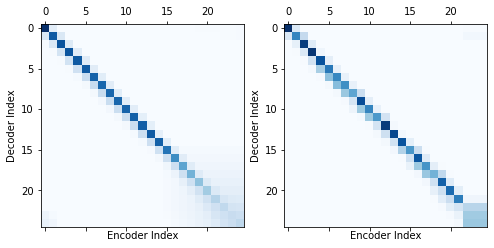

In [ ]:
from scipy.special import softmax
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
min_val, max_val = 0, 1

print('Single sequence shape:', hs[0].shape)
p_len = toy_params['phrase_length']
attn_matrix = np.zeros((len(hs), p_len, p_len))
for h_idx in range(len(hs)):
  enc_seq = hs[h_idx][:p_len]
  for seq_idx in range(p_len):
    attn_matrix[h_idx, seq_idx] = softmax(np.dot(enc_seq, hs[h_idx][p_len+seq_idx]))

mean_attn_matrix = np.mean(attn_matrix, axis=0)
ax1.matshow(mean_attn_matrix, cmap=plt.cm.Blues)
ax2.matshow(attn_matrix[0], cmap=plt.cm.Blues)

ax1.set_xlabel('Encoder Index')
ax1.set_ylabel('Decoder Index')
ax2.set_xlabel('Encoder Index')
ax2.set_ylabel('Decoder Index')

In [ ]:
soft_max_attn = jax.nn.softmax(att_params, axis=0)

fig, ax = plt.subplots()
min_val, max_val = 0, 1
ax.matshow(soft_max_attn, cmap=plt.cm.Blues)

### Find Fixed Points

In [ ]:
add_noise = True
noise_scale = 0.5
cell_type = 'enc'

word = '<pad>' # 'I0'
if word == None:
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

xstar = np.repeat(word_tensor[np.newaxis, :], pts[pts_subset].shape[0], axis=0)

if add_noise:
  seed_pts = pts[pts_subset] + np.random.normal(loc=0.0, scale=noise_scale, size=pts[pts_subset].shape)
else:
  seed_pts = pts[pts_subset]

if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(pts[pts_subset].shape)
    seed_pts = np.concatenate((seed_pts, null_hs), axis=1)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
xstar = jnp.asarray(xstar)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2)
print('Done')

if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  fixed_points = fixed_points[:, :rnn_specs['hidden_size']]

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Encoder fixed points.
Done
Fixed Points PR: 1.0157657504933155
% Var Exp: [9.9219364e-01 5.1310076e-03 2.0770244e-03 3.1081797e-04 1.2073886e-04]


Text(0, 0.5, 'PC5')

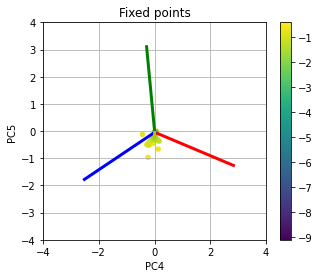

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0
y 1.0
x.y 7.4505806e-08


Text(0, 0.5, 'RO vec space2')

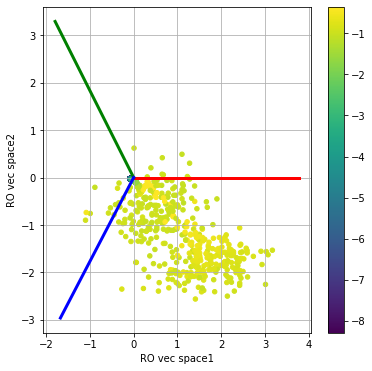

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)


fps_x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
fps_y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(fps_x_vals, fps_y_vals, s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()
plt.colorbar()

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

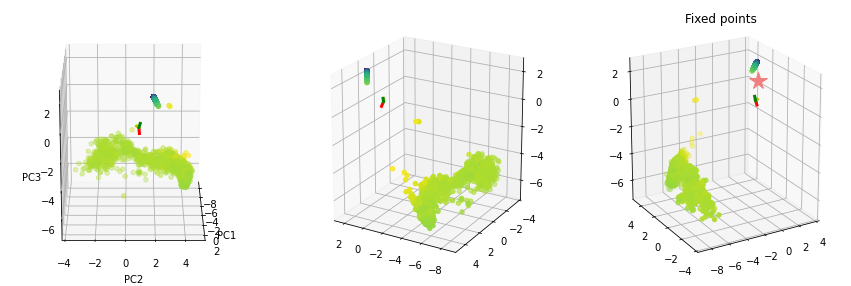

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  z_ro = [pca_zero[pc3], pca_ro[i][pc3]]
  ax.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))
  ax2.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))
  ax3.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 0)
ax2.view_init(20, 120)
ax3.view_init(20, 240)

#### Fixed Point Grid Search

Mean distance: 2.5539993485659362
Treshold conversion: 26.091650689900906


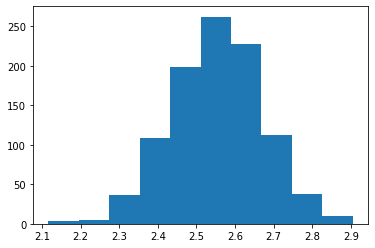

In [ ]:
# Average distance traveled
avg_step_sizes = np.zeros((len(hs),))
for hs_idx in range(len(hs)):
  hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
  total_dist = 0
  for time_idx in range(hs_h0.shape[0] - 1):
    total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
  avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

print('Mean distance:', np.mean(avg_step_sizes))
print('Treshold conversion:', (2*np.mean(avg_step_sizes))**2)

# Histogram of mean distance
plt.hist(avg_step_sizes, bins=10)
plt.show()

In [ ]:
cell_type = 'enc'
word = 'I0'
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts[pts_subset])
pr_hs = participation_ratio_vector(pca_full.explained_variance_)
print('Participation Ratio of Hidden States:', pr_hs)

grid_dims = np.int(np.ceil(pr_hs))
print("Grid over first {} PC dimensions".format(grid_dims))

range_extend_ratio = 1 # Amount to extend total range
max_points = 30 # Maximum points along biggest dimension
grid_coords = []
spacing = 0

for dim_idx in range(grid_dims):
  max_co = np.max(pts_pca[:,dim_idx])
  min_co = np.min(pts_pca[:,dim_idx])
  range_co = np.copy(max_co - min_co)

  max_co += range_extend_ratio/2 * range_co # Extend range
  min_co -= range_extend_ratio/2 * range_co

  if dim_idx == 0:
    spacing = (max_co - min_co)/max_points                                    

  if dim_idx == 2 or dim_idx == 3: # hack to set certain dimensions to zero points
    max_co, min_co = 1e-5, 0

  grid_coords.append(np.linspace(min_co, max_co, num=np.int(np.ceil((max_co - min_co)/spacing))))
  print('In PC{} dim, using {} points'.format(dim_idx, np.int(np.ceil((max_co - min_co)/spacing))))

# Creates grid and turns them into PCA points
grid_vals = np.asarray(np.meshgrid(*grid_coords))
grid_vals_flat = grid_vals.reshape(grid_vals.shape[0], np.prod(grid_vals.shape[1:]))
print('Total hidden states:',  np.prod(grid_vals.shape[1:]))
pca_points = np.zeros((grid_vals_flat.shape[1], rnn_specs['hidden_size']))
pca_points[:, :grid_dims] = grid_vals_flat.T

# Transform back into hidden state space
hs_grid_points =  jnp.asarray(pca_full.inverse_transform(pca_points))
if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
  null_hs = np.zeros(hs_grid_points.shape)
  hs_grid_points = np.concatenate((hs_grid_points, null_hs), axis=1)

print('Hs grid points shape', hs_grid_points.shape)

# Fixed point state search
hs_ones = jnp.ones((hs_grid_points.shape[0],))

xstar = np.repeat(word_tensor[np.newaxis, :], hs_grid_points.shape[0], axis=0)

if rnn_specs['arch'] == 'enc_dec':
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

fp_losses = fp_loss_fun(hs_grid_points, xstar)

Participation Ratio of Hidden States: 2.5238600957823096
Grid over first 3 PC dimensions
In PC0 dim, using 30 points
In PC1 dim, using 28 points
In PC2 dim, using 1 points
Total hidden states: 840
Hs grid points shape (840, 256)


In [ ]:
thresh = 1.0
hs_grid_thresh = hs_grid_points[fp_losses < thresh]
fp_losses_thresh = fp_losses[fp_losses < thresh]
print('Number of points', hs_grid_thresh.shape[0])

k_val = 100
r_range = (-0.5, 0)

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(hs_grid_thresh)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 

Number of points 548
Top 5 components: 1.0 ( [4.3972242e-01 4.2912185e-01 1.3115574e-01 2.8854531e-13 1.5325461e-15] )
Participation Ratio: 2.5335490180705964


#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

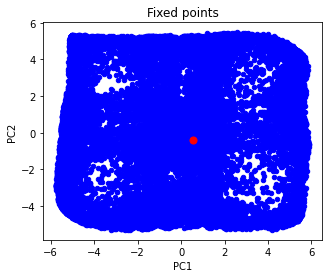

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 350
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

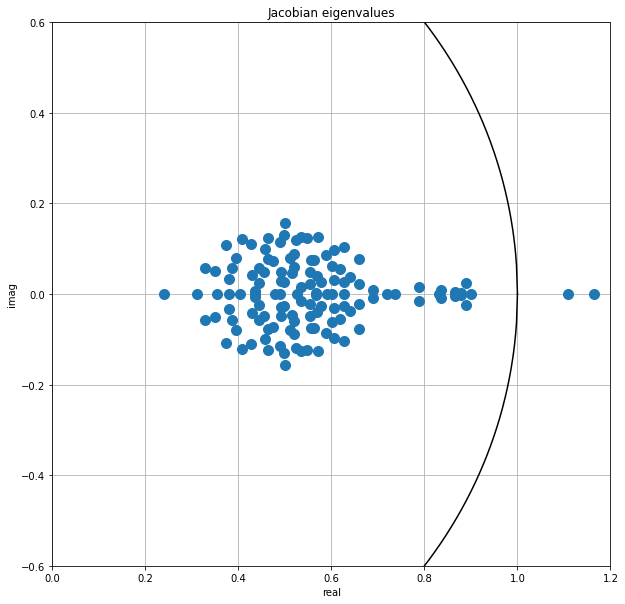

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 10000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

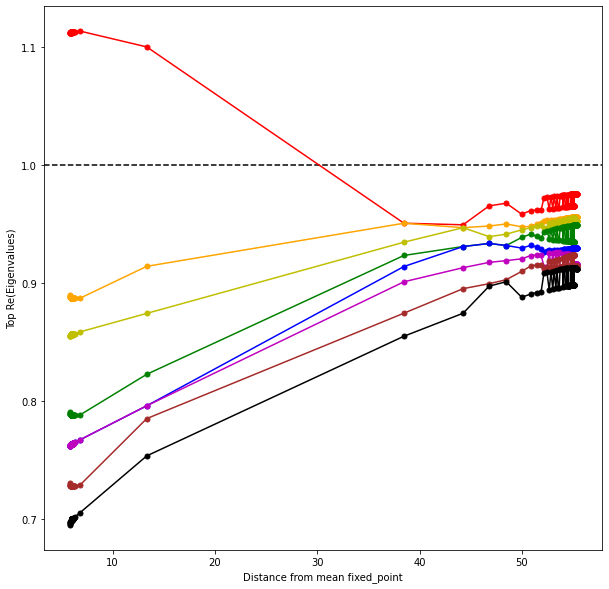

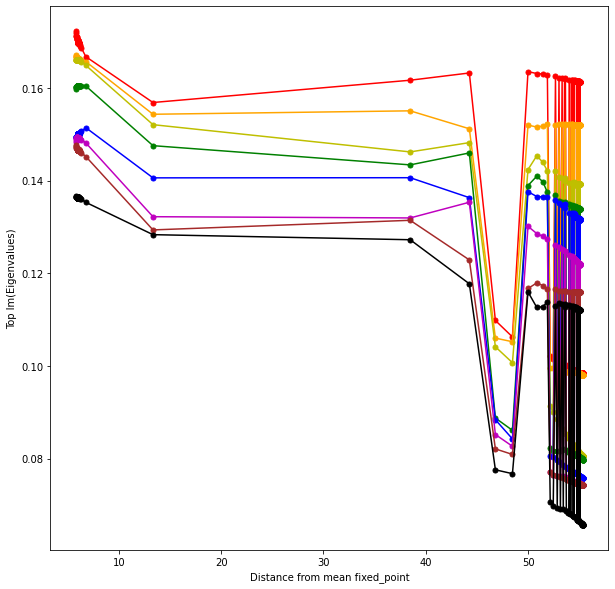

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

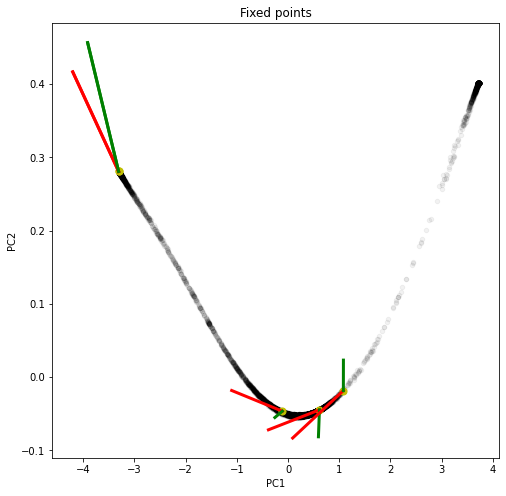

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

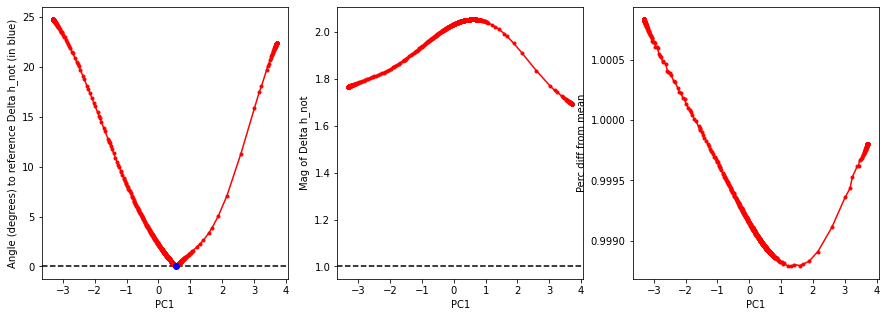

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

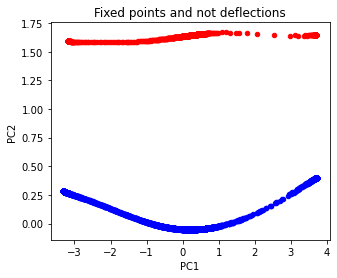

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

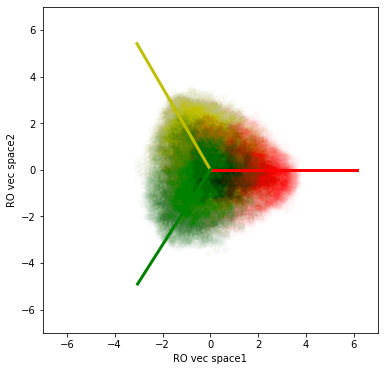

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

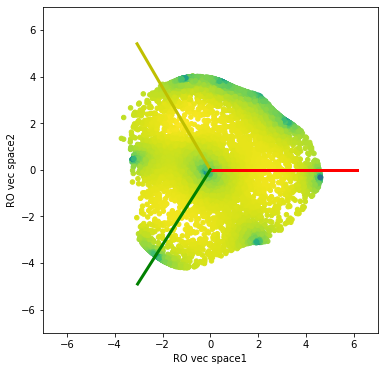

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

### Deflection Analysis

In [ ]:
# pts['enc'] = np.vstack([h[:toy_params['phrase_length']] for h in hs])
# pts['dec'] = np.vstack([h[toy_params['phrase_length']-1:] for h in hs])
time_idx = 15

deflections = [[] for _ in range(len(toy_params['in_words']))] # empty list for each word
all_defs = []
for h_idx in range(len(hs)):
  in_word_idx = np.argmax(syn_data_test['inputs'][h_idx, time_idx+1])
  # print('in_word_idx', in_word_idx)
  # print('h_idx', h_idx)
  # print('time_idx', time_idx)
  def_val = hs[h_idx][time_idx+1] - hs[h_idx][time_idx]
  deflections[in_word_idx].append(def_val)
  all_defs.append(def_val)

for defs in deflections:
  print('Length:', len(defs))

Length: 320
Length: 331
Length: 349


Deflection PR: 9.065678707510171
% Var Exp: [0.2028616  0.20016848 0.08871687 0.07161894 0.06420589]
Total_avg_def components [ 1.2902182  -2.4313135  -2.2475333   0.3257067  -0.5707205   0.07080135
 -0.4322221 ]
Mean Diff Components: [-0.02067721 -0.01190853  0.04214644 -0.24836788 -0.39044648 -0.22374338
  0.13212642]
Max diff idx: 4
Mean Diff Components: [ 0.0944345   0.08247399 -0.05580926 -0.17509626  0.43264973 -0.12282872
 -0.24518785]
Max diff idx: 4
Mean Diff Components: [-0.07060504 -0.0673039   0.01428747  0.39379546 -0.05233365  0.32164514
  0.11139429]
Max diff idx: 3


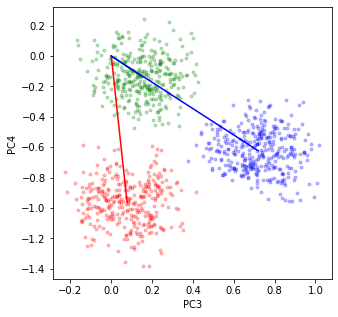

In [ ]:
plt.figure(figsize=(5,5))
axis_val = None
pc1 = 3
pc2 = 4

pca_defs = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_defs.fit_transform(all_defs)
print('Deflection PR:', participation_ratio_vector(pca_defs.explained_variance_ratio_))
print('% Var Exp:', pca_defs.explained_variance_ratio_[:5])

total_avg_def = np.mean(pca.transform(all_defs).T, axis=1)
print('Total_avg_def components', total_avg_def[:7])
avg_defs = []
for def_idx in range(len(deflections)):
  defs_pca = pca.transform(deflections[def_idx]).T
  avg_def = np.mean(defs_pca,axis=1)
  avg_defs.append(avg_def)
  mean_diff = avg_def - total_avg_def
  print('Mean Diff Components:', mean_diff[:7])
  print('Max diff idx:', np.argmax(np.abs(mean_diff)))

def_colors = ['r', 'g', 'b']
for def_idx in range(len(deflections)):
  defs_pca = pca.transform(deflections[def_idx]).T
  plt.scatter(defs_pca[pc1], defs_pca[pc2], color=def_colors[def_idx], marker='.', alpha=0.25)
  plt.plot([0, avg_defs[def_idx][pc1]], [0, avg_defs[def_idx][pc2]], color=def_colors[def_idx])

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
if axis_val != None:
  plt.xlim(-axis_val, axis_val)
  plt.ylim(-axis_val, axis_val)

x 1.0
y 0.99999994
x.y 1.0430813e-07


Text(0, 0.5, 'RO vec space2')

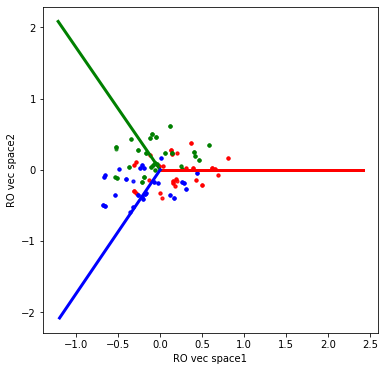

In [ ]:
# Project deflections onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

def_colors = ['r', 'g', 'b']
for def_idx in range(len(deflections)):
  x_vals = np.dot(np.matmul(np.vstack(deflections[def_idx]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(deflections[def_idx]), proj), y_basis)
  plt.scatter(x_vals, y_vals, color=def_colors[def_idx], marker='.', alpha=0.25)
  # plt.plot([0, avg_defs[def_idx][pc1]], [0, avg_defs[def_idx][pc2]], color=def_colors[def_idx])

for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], def_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

### FP Manifold Dimension


In [ ]:
unique_tol = 0.025
do_print = True
fps_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
# fps_reduced = fixed_points
n_fp = fps_reduced.shape[0]

time1 = time.time()
distances = pdist(fps_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 
print('Scipy Eucl Dist Time: {:0.2f} sec.'.format(time.time() - time1))
distances.sort()
print('Min dist:', distances[0])
print('Max dist:', distances[-1])

    Kept 2299/10000 unique fixed points with uniqueness tolerance 0.025000.
Scipy Eucl Dist Time: 0.26 sec.
Min dist: 0.02500274664486267
Max dist: 11.167172991811269


In [ ]:
def find_m_k(k, dist_sq):
  """
  Calculates m_k from Levina, Bickel (Eq. (9))
  
  k: Number of nearest neighbors
  dist_sq: n x n matrix of Euclidean distances between points
  """

  n = dist_sq.shape[0]
  
  m_ks = np.zeros((n,))
  k_eff = k + 1 # Self-distance included, so bump k up by one

  for idx in range(n): # Calculate m_k(x) for all x
    idx_dists = dist_sq[idx, :]
    kidxs = np.argpartition(idx_dists, k_eff)
    max_kdist = np.max(idx_dists[kidxs[:k_eff]])
    sum_of_logs = 0
    for i in range(k_eff):
      if idx_dists[kidxs[i]] > 0: # Ignores self distance
        sum_of_logs += np.log(max_kdist / idx_dists[kidxs[i]])
    m_ks[idx] = 1 / (1/(k - 1) * sum_of_logs)

  return np.mean(m_ks)


# k_vals = np.asarray([int(k_val) for k_val in range(50,80)])
# m_k_means = []
# for k_val in k_vals:
#   m_ks = np.zeros((n_fp,))
#   for i in range(n_fp):
#     m_ks[i] = find_m_k(i, k_val, dist_sq)
#   m_k_means.append(np.mean(m_ks))

k_val = 200
m_k_val = find_m_k(k_val, dist_sq)
print('m_k average:', m_k_val)

m_k average: 1.3098089897964853


k_avged Estimate: 2.033284748961476


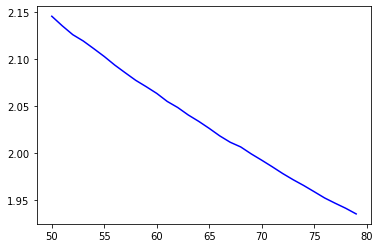

In [ ]:
print('k_avged Estimate:', 1/(np.max(k_vals)-np.min(k_vals)+1)*np.sum(m_k_means))

plt.figure()
plt.plot(k_vals, m_k_means, 'b')

Slope: 1.1424838189591549


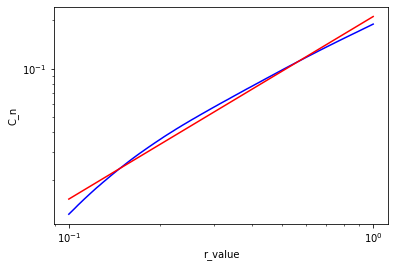

In [ ]:
import scipy
from scipy.spatial.distance import squareform

def find_correlation_dimension(r_val_range, dist_sq, num_pts=100, show_plot=False):
  """ 
  Calculates the linear regression fit of correlation dimension(r). The slope of said result is the estimated dimension

  r_val_range: log10(Range) of r values, specifically np.logspace(r[0], r[1]), 100)
  dist_sq: n x n matrix of Euclidean distances between points
  num_pts: number of points to fit

  Output: slope, intercept, r_value, p_value, std_err of linear regression fit
  """
  n = dist_sq.shape[0]
  distances = squareform(dist_sq)  # Changes to n * (n-1) / 2 vector
  r_values = np.logspace(r_val_range[0], r_val_range[1], num_pts)

  thresh_count = np.asarray([np.count_nonzero(distances < r_val) for r_val in r_values])
  c_n = 2/(n*(n - 1)) * thresh_count

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(r_values), np.log10(c_n))

  if show_plot: # Shows plot of fit
    plt.figure()
    plt.loglog(r_values, c_n, 'b')

    y_fit_values = np.asarray([10**intercept * r_val**slope for r_val in r_values])
    plt.loglog(r_values, y_fit_values, 'r')

    plt.xlabel('r_value')
    plt.ylabel('C_n')

  return slope, intercept, r_value, p_value, std_err

# r_range = (np.log10(1.1*distances[0]),np.log10(distances[-1])z)
r_range = (-1, 0)
slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=True)
print('Slope:', slope)

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

Using GRU cell
Sythentic data generated in: 0.17 sec.
Sythentic data generated in: 0.00 sec.
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
['kinda2', 'very1', 'the', 'very2', 'the']
Path label: 2, Rotating To: 0


In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

['kinda2', 'very1', 'the', 'very2', 'the', 'kinda2', 'kinda0', 'kinda2', 'the', 'very2', 'kinda0', 'kinda1', 'very2', 'kinda1', 'very2', 'very2', 'the', 'very1', 'very1', 'very0']
['kinda0', 'very2', 'the', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda2', 'kinda0', 'kinda2', 'kinda0', 'kinda0', 'the', 'very2', 'kinda2', 'kinda0']


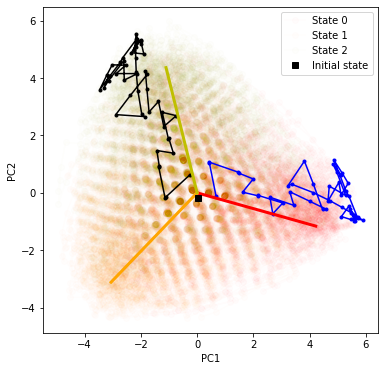

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

In [ ]:
# Shows flow of network at various locations in hidden-state space
add_noise = False
noise_scale = 0.01
cell_type = 'enc'

# flow_points_raw = fixed_points
flow_points_raw = hs_grid_points[:,:rnn_specs['hidden_size']]
# flow_points_raw = np.copy(pts)
if add_noise:
  flow_points_raw += np.random.normal(loc=0.0, scale=noise_scale, size=flow_points_raw.shape)

word = 'I0' #['O0', 'O1', 'O2']
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

# word_tensor = np.asarray([wordToTensor('not', toy_params['words'])[0], wordToTensor('very0', toy_params['words'])[0]])

# Filters out non-unique points
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)
steps = 1

points_reduced = points_unique #[::18]
points_final_pca = np.zeros((len(points_reduced), pc_dims))
# print(points_reduced.shape)
points_init_pca = pca.transform(np.vstack(points_reduced))
if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(points_reduced.shape)
    points_reduced = np.concatenate((points_reduced, null_hs), axis=1)
for pt_idx in range(len(points_reduced)):
  ref_point = points_reduced[pt_idx]
  for step in range(steps):
    if rnn_specs['arch'] == 'enc_dec' and cell_type == 'dec':
      def_state = cell_dec.apply(rnn_params_dec, word_tensor, ref_point)
    else:
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
    ref_point = def_state
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(def_state[:rnn_specs['hidden_size']]))[0]
  
print(points_init_pca.shape)
print(points_final_pca.shape)

    Kept 840/840 unique fixed points with uniqueness tolerance 0.500000.
(840, 10)
(840, 10)


Text(0, 0.5, 'PC1')

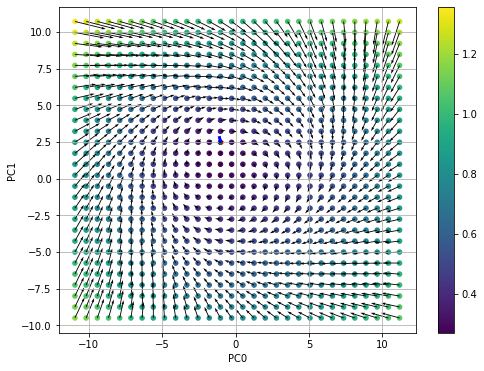

In [ ]:
plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

# pca_fps = pca.transform(np.vstack(fixed_points)).T
pca_fps = pca.transform(np.vstack(hs_grid_points[:,:rnn_specs['hidden_size']])).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.pcolormesh(pca_fps[pc1].reshape(30, 26), pca_fps[pc2].reshape(30, 26), np.log10(fp_losses.reshape(30, 26)))
plt.grid()

plt.colorbar()

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], points_final_pca[:,pc1]-points_init_pca[:,pc1], 
           points_final_pca[:,pc2]-points_init_pca[:,pc2], units='xy', scale=3)

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

In [ ]:
pc1 = 0
pc2 = 1

deflection_mags = np.zeros((points_init_pca.shape[0]))
counter = 0
for fp_init, fp_final, idx in zip(points_init_pca, points_final_pca, range(points_init_pca.shape[0])):
  deflection = np.asarray([fp_final[pc1] - fp_init[pc1], fp_final[pc2] - fp_init[pc2]])
  deflection_mags[idx] = np.linalg.norm(deflection)

print(np.max(deflection_mags))
print(np.min(deflection_mags))
deflection_mags.sort()

plt.plot(deflection_mags)